# Hidden Markov Model for Regime Detection

This notebook implements a Gaussian Hidden Markov Model (HMM) to identify market regimes (bull and bear markets) using weekly SPY and GLD data.

In [34]:
import pandas as pd
import numpy as np
from hmmlearn.hmm import GaussianHMM
from hmmlearn.hmm import GMMHMM
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")

# Load and Preprocess Data

1.  Load the daily SPY and GLD price data.
2.  Set the 'Date' column as the index.
3.  Remove rows with missing 'SPY' values.
4.  Resample the data to a weekly frequency, using the last price of each week.
5.  Calculate the weekly percentage change in prices to get the returns.

In [5]:
#Import data
df = pd.read_csv('data/spy_gld.csv', index_col='Date', parse_dates=True)

#Drop rows with missing SPY data
df.dropna(subset=['SPY'], inplace=True)

#Resample to weekly data, using Friday's data
df_weekly = df.asfreq('W-FRI').ffill()

#Calculate weekly returns
df_returns = df_weekly.pct_change().dropna()

df_returns.head()

,SPY,GLD
Date,,
2004-11-26,0.011389,0.007920
2004-12-03,0.006845,0.007604
2004-12-10,-0.047368,0.000671
2004-12-17,0.017265,0.005650
2004-12-24,0.000000,0.000000


# Base Strategy

## Implement Gaussian HMM

In [69]:
#Define the parameters and the HMM model
window_size = 104   # 104 weeks
n_components = 2    #The two states are the two regimes
strategy_returns_GaussHMM = []

model = GaussianHMM(n_components=n_components, covariance_type="diag", n_iter=1000, random_state=1806)



#Walk forward loop
for i in range(window_size, len(df_returns) - 1):

    #
    train_data_raw = df_returns.iloc[i - window_size:i]
    test_index = df_returns.index[i]

    scaler = StandardScaler()
    train_data = scaler.fit_transform(train_data_raw[['SPY']])

    model = GaussianHMM(n_components=2, covariance_type='diag', n_iter=100, random_state=1806)
    model.fit(train_data)

    #Transition probability
    posteriors = model.predict_proba(train_data)
    pi_t = posteriors[-1]   #Vector with the probablity of being in each state
    pi_next = pi_t @ model.transmat_    #Get the prob of being in each state in the next step

    #Predict states
    states = model.predict(train_data)
    train_data_raw['State'] = states

    state_returns = train_data_raw.groupby('State')['SPY'].mean()
    high_risk_state = state_returns.idxmin()

    #Asset allocation
    weight_gld = pi_next[high_risk_state]
    weight_spy = 1 - weight_gld

    r_spy = df_returns.loc[test_index, 'SPY']
    r_gld = df_returns.loc[test_index, 'GLD']
    strategy_return = np.log(weight_spy * np.exp(r_spy) + weight_gld * np.exp(r_gld) )

    strategy_returns_GaussHMM.append((test_index, strategy_return, r_spy, r_gld, weight_gld))

## Strategy results


In [70]:
strategy_df = pd.DataFrame(strategy_returns_GaussHMM, columns=['Date', 'Strategy_Return_GaussHMM', 'SPY_Return', 'GLD_Return', 'GLD_Weight'])
strategy_df.set_index( 'Date', inplace=True)
strategy_df['Cumulative_Strategy_GaussHMM'] = (1+strategy_df['Strategy_Return_GaussHMM']).cumprod()
strategy_df['Cumulative_SPY']= (1 + strategy_df ['SPY_Return']).cumprod()
strategy_df['Cumulative_GLD']= (1 + strategy_df ['GLD_Return']).cumprod()
strategy_df

,Strategy_Return_GaussHMM,SPY_Return,GLD_Return,GLD_Weight,Cumulative_Strategy_GaussHMM,Cumulative_SPY,Cumulative_GLD
Date,,,,,,,
2006-11-24,0.005390,0.027841,-0.000498,0.794529,1.005390,1.027841,0.999502
2006-12-01,0.002668,0.009764,-0.000926,0.664950,1.008073,1.037876,0.998576
2006-12-08,-0.026905,-0.032283,0.008558,0.129376,0.980951,1.004370,1.007122
2006-12-15,-0.006504,-0.016922,0.012114,0.355479,0.974572,0.987375,1.019321
2006-12-22,-0.004686,0.010656,-0.011170,0.705198,0.970005,0.997896,1.007935
...,...,...,...,...,...,...,...
2025-06-27,-0.002503,-0.028730,0.034714,0.405701,7.173414,4.875688,6.227373
2025-07-04,0.000000,0.000000,0.000000,0.567062,7.173414,4.875688,6.227373
2025-07-11,0.019796,0.026293,0.014165,0.537183,7.315420,5.003885,6.315582


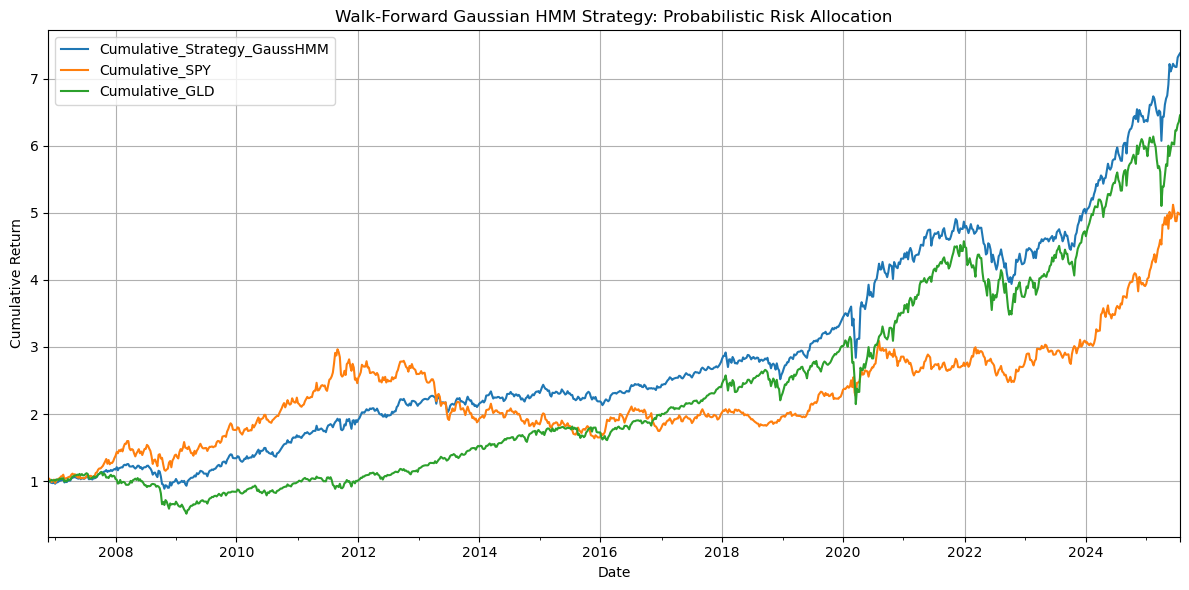

In [71]:
strategy_df[['Cumulative_Strategy_GaussHMM', 'Cumulative_SPY','Cumulative_GLD']].plot(figsize=(12, 6))
plt.title("Walk-Forward Gaussian HMM Strategy: Probabilistic Risk Allocation")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.tight_layout()
plt.show()

In [57]:
def compute_stats(returns, freq='W'):
    periods_per_year = {'D': 252, 'W': 52, 'M': 12}[freq]

    #CAGR
    cumulative_return = (1 + returns).prod()
    n_periods = len(returns)
    years = n_periods / periods_per_year
    cagr = cumulative_return ** (1 / years) - 1

    #Max and average drawdown
    rolling = (1 + returns).cumprod()
    peak = rolling.cummax()
    drawdown = (rolling - peak) / peak
    max_dd = drawdown.min()
    avg_dd = drawdown[drawdown < 0].mean()

    # Sharpe Ratio
    volatility = returns.std() * np.sqrt(periods_per_year)  #for simplicity risk free rate is 0
    sharpe = returns.mean() / returns.std() * np.sqrt(periods_per_year) # it is still a good metric to compare risk and return between different models

    return {
        'CAGR': cagr,
        'Max Drawdown': max_dd,
        'Average Drawdown': avg_dd,
        'Sharpe Ratio': sharpe
    }

In [78]:
stats_strategy = compute_stats(strategy_df['Strategy_Return_GaussHMM'], freq='W')
stats_spy = compute_stats(strategy_df['SPY_Return'], freq='W')
stats_gld = compute_stats(strategy_df['GLD_Return'],freq='W' )

report = pd.DataFrame(
    [stats_strategy, stats_spy, stats_gld],
    index=['GaussHMM strategy', 'SPY', 'GLD']
)
print(report.round(4))

                     CAGR  Max Drawdown  Average Drawdown  Sharpe Ratio
GaussHMM strategy  0.1125       -0.2926           -0.0489        0.8263
SPY                0.0893       -0.4474           -0.1838        0.5969
GLD                0.1045       -0.5461           -0.0999        0.6316


strategia sembra funzionare bene ma confrontiamola con una strategia di base molto semplice, ovvero 50/50

In [75]:
strategy_df['Mixed_Returns'] = np.log( 0.5 * np.exp(strategy_df['SPY_Return']) + 0.5 * np.exp(strategy_df['GLD_Return']) )
strategy_df['Cumulative_Mixed'] = (1+strategy_df['Mixed_Returns']).cumprod()

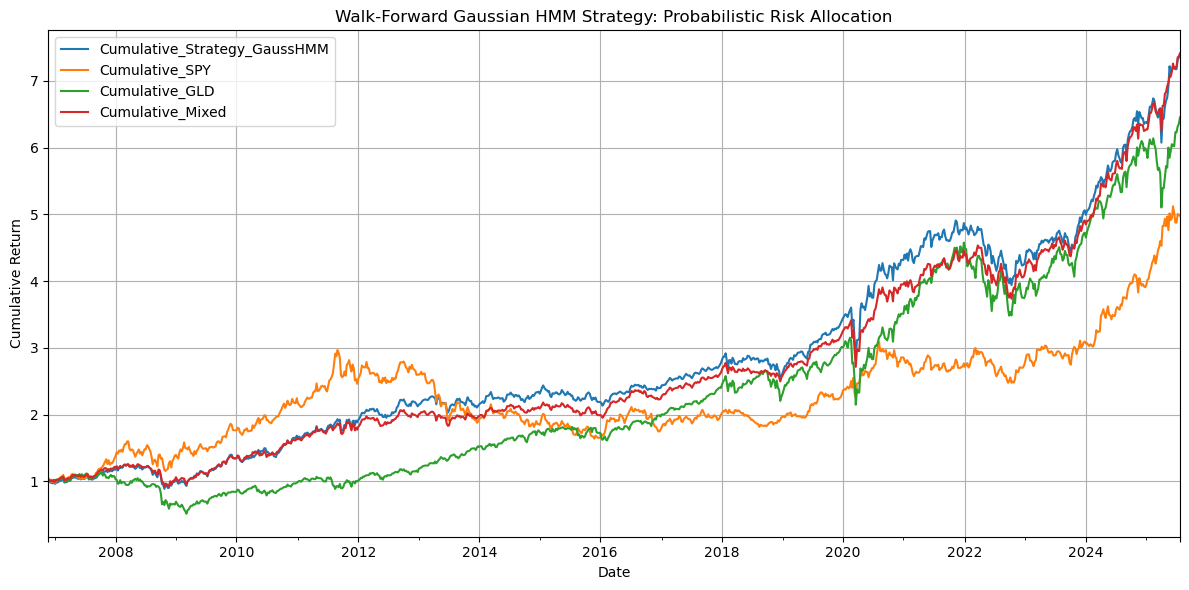

In [76]:
strategy_df[['Cumulative_Strategy_GaussHMM', 'Cumulative_SPY','Cumulative_GLD','Cumulative_Mixed']].plot(figsize=(12, 6))
plt.title("Walk-Forward Gaussian HMM Strategy: Probabilistic Risk Allocation")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.tight_layout()
plt.show()

In [79]:
stats_mixed = compute_stats(strategy_df['Mixed_Returns'],freq='W' )

report = pd.DataFrame(
    [stats_strategy, stats_spy, stats_gld, stats_mixed],
    index=['GaussHMM strategy', 'SPY', 'GLD','50/50']
)

print(report.round(4))

                     CAGR  Max Drawdown  Average Drawdown  Sharpe Ratio
GaussHMM strategy  0.1125       -0.2926           -0.0489        0.8263
SPY                0.0893       -0.4474           -0.1838        0.5969
GLD                0.1045       -0.5461           -0.0999        0.6316
50/50              0.1127       -0.2689           -0.0418        0.8925


Non abbiamo battuto portafoglio benchmark 50/50, proviamo ad apportare modifiche al modello.

Modifichiamo l'assumption dei gaussian returns, proviamo a utilizzare una gaussian mixture. solitamente si usano da 2 a 4 gaussiane.

# GMM Strategy

## Implement GMM HMM

In [81]:
#Define the parameters and the HMM model
window_size = 104   # 104 weeks
n_components = 2    #The two states are the two regimes
n_mix = 3 #number of Gaussian
strategy_returns_GMMHMM = []

model = GaussianHMM(n_components=n_components, covariance_type="diag", n_iter=100, random_state=1806)


#Walk forward loop
for i in range(window_size, len(df_returns) - 1):

    #Select only data from the window selected
    train_data_raw = df_returns.iloc[i - window_size:i]
    test_index = df_returns.index[i]

    scaler = StandardScaler()
    train_data = scaler.fit_transform(train_data_raw[['SPY']])

    model = GMMHMM(n_components=2, n_mix = n_mix, covariance_type='diag', n_iter=100, random_state=1806)
    model.fit(train_data)

    #Transition probability
    posteriors = model.predict_proba(train_data)
    pi_t = posteriors[-1]   #Vector with the probablity of being in each state
    pi_next = pi_t @ model.transmat_    #Get the prob of being in each state in the next step

    #Predict states
    states = model.predict(train_data)
    train_data_raw['State'] = states

    state_returns = train_data_raw.groupby('State')['SPY'].mean()
    high_risk_state = state_returns.idxmin()

    #Asset allocation
    weight_gld = pi_next[high_risk_state]
    weight_spy = 1 - weight_gld

    r_spy = df_returns.loc[test_index, 'SPY']
    r_gld = df_returns.loc[test_index, 'GLD']
    strategy_return = np.log(weight_spy * np.exp(r_spy) + weight_gld * np.exp(r_gld) )

    strategy_returns_GMMHMM.append((test_index, strategy_return, r_spy, r_gld, weight_gld))

Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate

In [84]:
strategy_df = pd.DataFrame(strategy_returns_GMMHMM, columns=[ 'Date', 'Strategy_Return_GMMHMM', 'SPY_Return', 'GLD_Return', 'GLD_Weight'])
strategy_df.set_index( 'Date', inplace=True)
strategy_df['Cumulative_Strategy_GMMHMM'] = (1+strategy_df['Strategy_Return_GMMHMM']).cumprod()
strategy_df['Cumulative_SPY'] = (1 + strategy_df ['SPY_Return']).cumprod()
strategy_df['Cumulative_GLD'] = (1 + strategy_df ['GLD_Return']).cumprod()
strategy_df['Mixed_Returns'] = np.log( 0.5 * np.exp(strategy_df['SPY_Return']) + 0.5 * np.exp(strategy_df['GLD_Return']) )
strategy_df['Cumulative_Mixed'] = (1+strategy_df['Mixed_Returns']).cumprod()

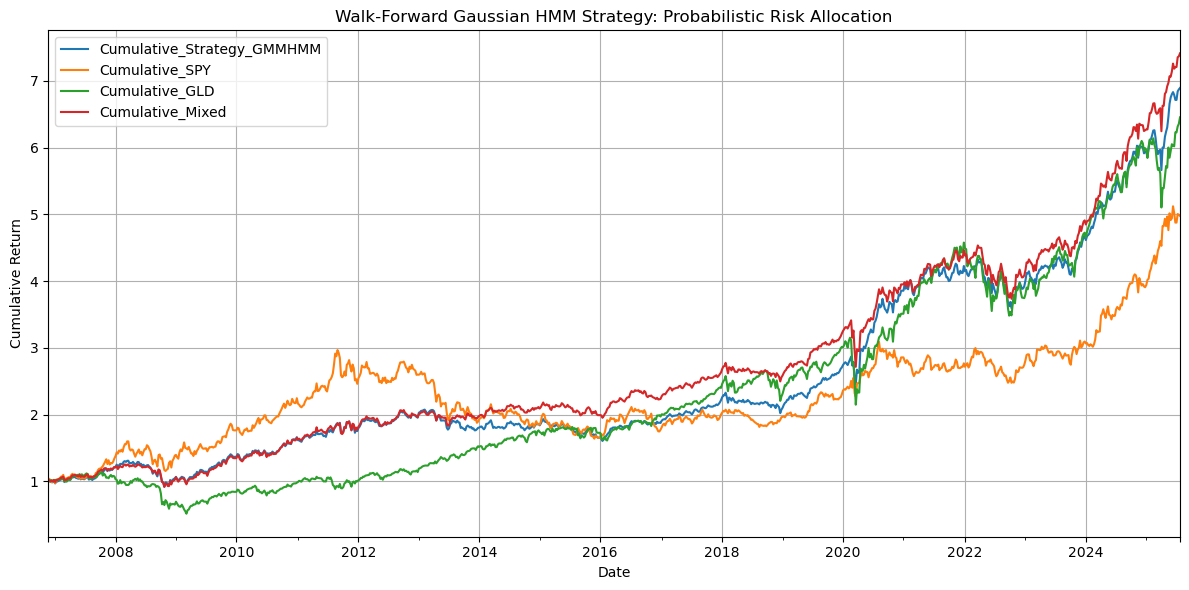

In [85]:
strategy_df[['Cumulative_Strategy_GMMHMM', 'Cumulative_SPY','Cumulative_GLD','Cumulative_Mixed']].plot(figsize=(12, 6))
plt.title("Walk-Forward Gaussian HMM Strategy: Probabilistic Risk Allocation")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.tight_layout()
plt.show()

In [86]:
stats_strategy = compute_stats(strategy_df['Strategy_Return_GMMHMM'], freq='W')
stats_spy = compute_stats(strategy_df['SPY_Return'], freq='W')
stats_gld = compute_stats(strategy_df['GLD_Return'],freq='W' )
stats_mixed = compute_stats(strategy_df['Mixed_Returns'],freq='W' )

report = pd.DataFrame(
    [stats_strategy, stats_spy, stats_gld, stats_mixed],
    index=['GMMHMM strategy', 'SPY', 'GLD','50/50']
)

print(report.round(4))

                   CAGR  Max Drawdown  Average Drawdown  Sharpe Ratio
GMMHMM strategy  0.1084       -0.2994           -0.0666        0.8327
SPY              0.0893       -0.4474           -0.1838        0.5969
GLD              0.1045       -0.5461           -0.0999        0.6316
50/50            0.1127       -0.2689           -0.0418        0.8925
